## 1️⃣ [Week3/심화] Multi-genre natural language inference(MNLI)

MNLI는 두 문장이 주어졌을 때 논리적으로 연결이 되어 있는지, 서로 모순되는지, 아니면 아예 무관한지 분류하는 문제입니다.

* data : https://www.kaggle.com/datasets/thedevastator/unlocking-language-understanding-with-the-multin

### 1. 데이터 불러오기

In [1]:
import random
import pandas as pd

In [7]:
train_df = pd.read_csv('./train.csv', encoding='latin1')
test_df = pd.read_csv('./validation_matched.csv')

In [8]:
print("** train **")
print(f"train len : {len(train_df)}")
print(train_df.columns)
print("** test **")
print(f"test len : {len(test_df)}")

** train **
train len : 83530
Index(['promptID', 'pairID', 'premise', 'premise_binary_parse',
       'premise_parse', 'hypothesis', 'hypothesis_binary_parse',
       'hypothesis_parse', 'genre', 'label'],
      dtype='object')
** test **
test len : 9815


#### 📋 MNLI 데이터셋 칼럼 설명
|칼럼 이름|설명|
|--|--|
|promptID	|원본 문서나 문단 단위의 ID. |
|pairID|	각 문장 쌍의 고유 식별자.|
|premise	|전제 문장.|
|premise_binary_parse	|전제 문장의 binary constituency 구문 트리 (문법 구조 파싱 결과, 괄호로 표현됨).|
|premise_parse	|전제 문장의 full constituency 구문 트리. |
|hypothesis	|가설 문장. premise를 기반으로 이 문장이 참인지 아닌지를 판단|
|hypothesis_binary_parse|	가설 문장의 binary 구문 트리.|
|hypothesis_parse	|가설 문장의 full constituency 구문 트리.|
|genre	|문장 쌍이 나온 도메인/장르 (예: fiction, slate, telephone, travel, government 등). 모델이 도메인 일반화 능력을 가질 수 있게 도와주는 요소.|
|label|	정답 레이블. entailment, contradiction, neutral, 또는 - (레이블 없음: 예측 대상일 때 사용).|

결굴 premise와 hypothesis의 관계를 pred 해야하는 것이고 정답은 label에 있으므로 이 3개 column을 사용하면 된다.

##### 데이터 확인 및 전처리

* 결측치 확인
* train 데이터 분포 확인 (불균형한지)
* label의 의미 확인

In [9]:
train_df = train_df[['premise','hypothesis','label']]
test_df = test_df[['premise','hypothesis','label']]
train_df.head()

,premise,hypothesis,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1.0
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0.0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0.0
3,How do you know? All this is their information...,This information belongs to them.,0.0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1.0


In [10]:
print("** train **")
print(train_df.isnull().sum())
print("** test **")
print(test_df.isnull().sum())

** train **
premise        0
hypothesis    13
label          1
dtype: int64
** test **
premise       0
hypothesis    0
label         0
dtype: int64


In [11]:
## 결측치 제거
before_len = len(train_df)
train_df = train_df.dropna()
after_len = len(train_df)

print(f"{before_len - after_len} rows dropped.")

13 rows dropped.


* 결측치를 제거하고 label이 값이 3개인지 확인한다.

In [12]:
train_df['label'].unique()

array([1., 0., 2.])

* train 데이터가 불균형한지도 확인해준다.

In [13]:
train_df['label'].value_counts()

,count
label,
2.0,29539
0.0,28285
1.0,25693


In [14]:
for label in train_df['label'].unique():
    examples = train_df[train_df['label'] == label].sample(3)
    print(f"\nLabel {label} 예시:")
    for i, row in examples.iterrows():
        print(f"- Premise: {row['premise']}")
        print(f"  Hypothesis: {row['hypothesis']}")


Label 1.0 예시:
- Premise: Of course, as stated earlier, the effectiveness of this principle is moderated by the extent to which the other principles have been implemented.
  Hypothesis: Without the application of the other principles, this principle stands no change of success.
- Premise: More men attacked and Jon cut them down.
  Hypothesis: More people ran up with their swords drawn.
- Premise: It weighed about a kilo and was the size of a bag of flour.
  Hypothesis: He had one kilo of weed stored in the bag. 

Label 0.0 예시:
- Premise: uh-huh my daughter watches that religiously we tape it for her because it comes on at nine here and she has to go to bed at eight thirty and uh so that you know we watch it too while we're taping it we watch it
  Hypothesis: My daughter likes to watch a television show that comes on after she has already gone to bed. 
- Premise: And there was another Abraham Lincoln.
  Hypothesis: There was more than one Abraham Lincoln. 
- Premise: isn't that the trut

어떤 라벨이 어떤 뜻인지 헷갈렸는데 예시 찍어보고 다시 확인

* label 0 - Entailment
  * 의미가 거의 같거나, 하나가 다른 하나로부터 도출됨
* label 1 - Neutral
* Label 2 - Contradiction
  * 전제와 가설이 명백히 상반됨

### 2. dataset 준비

(여러 모델을 테스트 하기 위해 재사용성 있는 코드)
* tokenizer 불러오기


In [15]:
from transformers import AutoTokenizer

def get_tokenizer(model_name):
    return AutoTokenizer.from_pretrained(model_name)

* dataset 만들기
 * collate_fn 안에서 여러 처리를 해주고 이 안에선 pair로만 만들어준다.

In [16]:
from torch.utils.data import Dataset

class Dataset_Maker(Dataset):
    def __init__(self, df):
        self.pairs = list(zip(df['premise'], df['hypothesis']))
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text_pair': self.pairs[idx],
            'label': self.labels[idx]
        }

* collate_fn
  * premises와 hypotheses를 한 문장 쌍으로 만듬
  * 패딩 처리
  * truncation 처리
  * masking은 attention_mask 사용

In [17]:
import torch

def collate_fn(batch, tokenizer, max_length=256):
    premises, hypotheses = zip(*[item['text_pair'] for item in batch])
    labels = [item['label'] for item in batch]

    encodings = tokenizer(
        list(premises),
        list(hypotheses),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    encodings['labels'] = torch.tensor(labels, dtype=torch.long)
    return encodings

tokenizer의 max_length를 확인해서 collate_fn에 넘겨주어 모델을 바꾸더라도 문제가 없도록 처리해준다.

In [18]:
model_name = "distilbert-base-uncased"

In [19]:
from torch.utils.data import DataLoader

tokenizer = get_tokenizer(model_name)

def get_dataloader(tokenizer, train_df, test_df, batch_size):
    max_length = tokenizer.model_max_length

    train_ds = Dataset_Maker(train_df)
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length)
    )

    test_ds = Dataset_Maker(test_df)
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length)
    )
    return train_loader, test_loader

train_loader, test_loader = get_dataloader(tokenizer, train_df, test_df, 32)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### 3. Model 구성
* pretrained model 불러오기
* MNLIClassifier 구조잡기

In [20]:
import torch.nn as nn
from transformers import AutoModel

In [32]:
class MNLIClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.pretrained_model = AutoModel.from_pretrained(model_name)
        hidden_size = self.pretrained_model.config.hidden_size

        self.classifier = nn.Linear(hidden_size, 3)

        print(f"** load pretrained model {model_name} **")
        print(self.pretrained_model)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS 위치
        pred_output = self.classifier(cls_output)
        return pred_output


In [33]:
model = MNLIClassifier(model_name)

** load pretrained model distilbert-base-uncased **
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=76

In [34]:
print(model)

MNLIClassifier(
  (pretrained_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [35]:
for param in model.pretrained_model.parameters():
    param.required_grad=False

### 4. finetuning

In [36]:
def evaluate_acc(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct/total

In [37]:
def model_eval(model, dataloader, device):
    model.eval()
    total_loss = 0
    total_acc = 0
    total_count = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = nn.functional.cross_entropy(logits, labels)

            preds = logits.argmax(dim=1)
            acc = evaluate_acc(preds, labels)

            total_loss += loss.item()
            total_acc += acc * labels.size(0)
            total_count += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / total_count
    return avg_loss, avg_acc


In [41]:
def model_train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs):
    device = 'cuda'
    loss_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/num_epochs"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            preds = model(input_ids, attention_mask)

            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss

        val_loss, val_acc = model_eval(model, test_loader, device)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        loss_list.append(train_loss)
        test_acc_list.append(val_acc)
    return loss_list, test_acc_list


In [43]:
from torch.optim import Adam, AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 3

loss_list, test_acc = model_train(model, train_loader, test_loader, optimizer, loss_fn, n_epochs)

Epoch 1/num_epochs: 100%|██████████| 2610/2610 [10:44<00:00,  4.05it/s]


[Epoch 1] Train Loss: 2874.3411 | Val Loss: 1.0995 | Val Acc: 0.3274


Epoch 2/num_epochs: 100%|██████████| 2610/2610 [10:41<00:00,  4.07it/s]


[Epoch 2] Train Loss: 2865.9317 | Val Loss: 1.1011 | Val Acc: 0.3274


Epoch 3/num_epochs: 100%|██████████| 2610/2610 [10:42<00:00,  4.06it/s]


[Epoch 3] Train Loss: 2865.9874 | Val Loss: 1.1008 | Val Acc: 0.3274


In [45]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss_list, acc_list):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_list, marker='o')
    plt.title("Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acc_list, marker='o')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


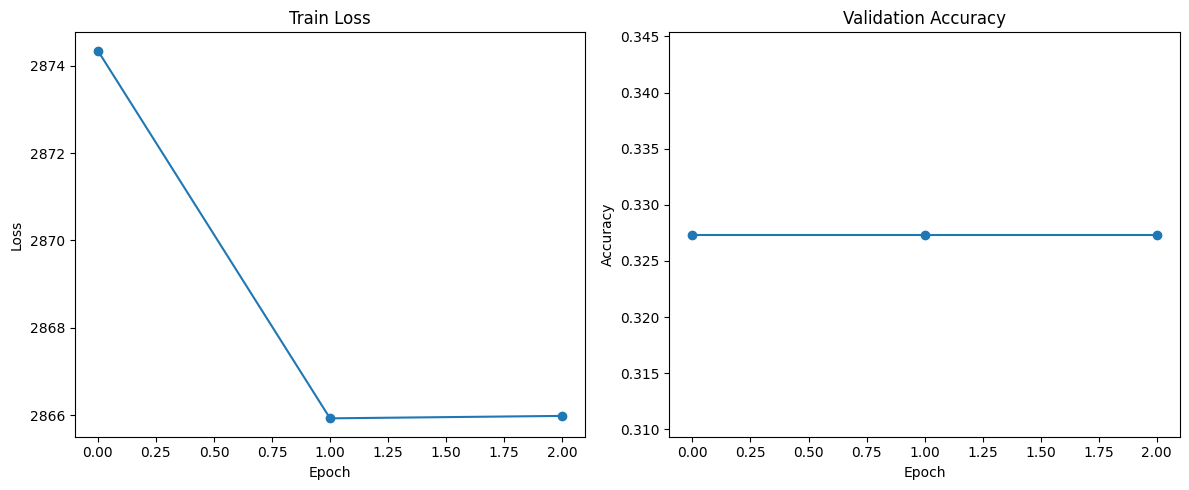

In [46]:
plot_loss_accuracy(loss_list, test_acc)

epoch 별로 개선되지 않는걸 확인할 수 있었다.

In [54]:
def compare_accuracy(acc_list_1, acc_list_2, label1="Model 1", label2="Model 2"):
    epochs = range(1, len(acc_list_1) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc_list_1, marker='o', label=label1)
    plt.plot(epochs, acc_list_2, marker='o', label=label2)
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

---
#### 변형 1
* lr 낮추기
* dropout 추가

In [47]:
class MNLIClassifierWithDropout(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name
        self.pretrained_model = AutoModel.from_pretrained(model_name)
        hidden_size = self.pretrained_model.config.hidden_size

        self.classifier = nn.Linear(hidden_size, 3)
        self.dropout = nn.Dropout(0.1)

        print(f"** load pretrained model {model_name} **")
        print(self.pretrained_model)

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.pretrained_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS 위치
        cls_output = self.dropout(cls_output)
        pred_output = self.classifier(cls_output)
        return pred_output


In [48]:
model = MNLIClassifierWithDropout(model_name)
model = model.to('cuda')

** load pretrained model distilbert-base-uncased **
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=76

In [49]:
for param in model.pretrained_model.parameters():
    param.required_grad=False

In [50]:
lr = 2e-5
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 3

loss_list_2, test_acc_2 = model_train(model, train_loader, test_loader, optimizer, loss_fn, n_epochs)

Epoch 1/num_epochs: 100%|██████████| 2610/2610 [10:44<00:00,  4.05it/s]


[Epoch 1] Train Loss: 1871.2026 | Val Loss: 0.6012 | Val Acc: 0.7546


Epoch 2/num_epochs: 100%|██████████| 2610/2610 [10:45<00:00,  4.04it/s]


[Epoch 2] Train Loss: 1306.2998 | Val Loss: 0.5936 | Val Acc: 0.7673


Epoch 3/num_epochs: 100%|██████████| 2610/2610 [10:46<00:00,  4.04it/s]


[Epoch 3] Train Loss: 903.2399 | Val Loss: 0.6405 | Val Acc: 0.7752


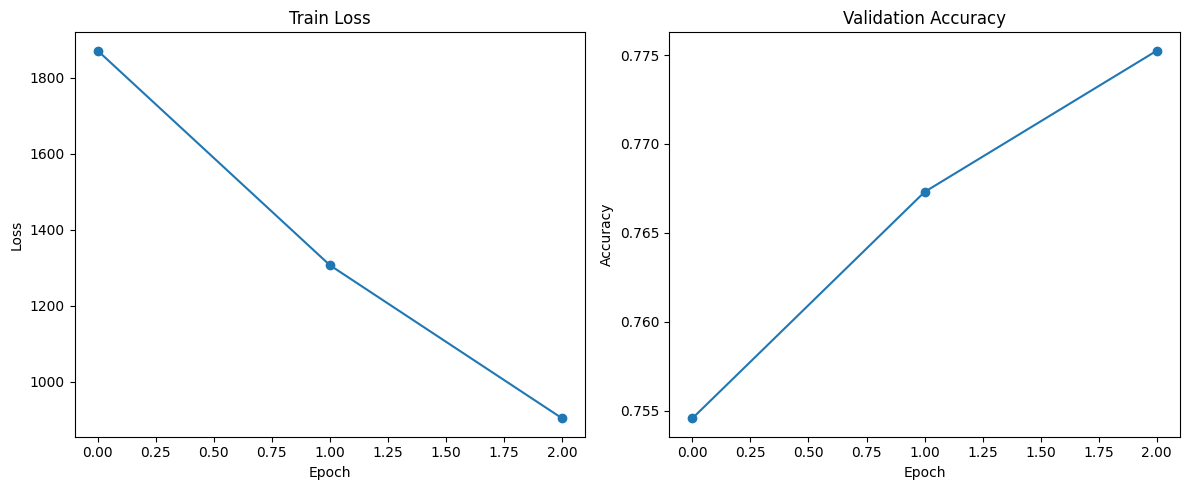

In [52]:
plot_loss_accuracy(loss_list_2, test_acc_2)

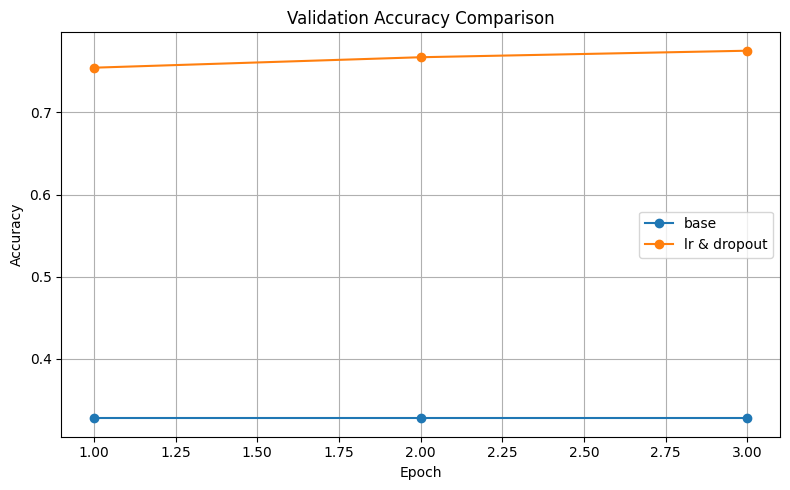

In [55]:
compare_accuracy(test_acc, test_acc_2, "base", "lr & dropout")

성능이 엄청 차이나는 걸 확인할 수 있다. 두개중에 어떤 영향인지 확인해보고 싶다.

#### dropout 만 수정

In [ ]:
model3 = MNLIClassifierWithDropout(model_name)
model3 = model.to('cuda')
for param in model3.pretrained_model.parameters():
    param.required_grad=False

lr = 0.001
optimizer = Adam(model3.parameters(), lr=lr)
n_epochs = 3

loss_list_3, test_acc_3 = model_train(model3, train_loader, test_loader, optimizer, loss_fn, n_epochs)

** load pretrained model distilbert-base-uncased **
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=76

Epoch 1/num_epochs: 100%|██████████| 2610/2610 [10:42<00:00,  4.06it/s]


[Epoch 1] Train Loss: 2870.9495 | Val Loss: 1.0978 | Val Acc: 0.3545


Epoch 2/num_epochs:  50%|█████     | 1315/2610 [05:22<06:37,  3.26it/s]

In [ ]:
compare_accuracy(test_acc, test_acc_3, "base", "dropout")

#### lr만 수정

In [ ]:
model4 = MNLIClassifier(model_name)
model4 = model.to('cuda')
for param in model4.pretrained_model.parameters():
    param.required_grad=False

lr = 2e-5
optimizer = Adam(model4.parameters(), lr=lr)
n_epochs = 3

loss_list_4, test_acc_4 = model_train(model4, train_loader, test_loader, optimizer, loss_fn, n_epochs)

In [ ]:
compare_accuracy(test_acc, test_acc_4, "base", "lr")